In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import column_or_1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Загрузка данных
data = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

data

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.841559,-73.942528,12.0,10.0,255.0,Washington Heights South ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,14988,4940453,Advanced: 24 Monroe Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3002380026,3-00238-0026\t,3001927,24 Monroe Place,Not Available,...,109.6,04/26/2017 11:20:06 AM,NaN,NaN,40.696420,-73.992495,2.0,33.0,502.0,Brooklyn Heights-Cobble Hill ...
11742,14989,4940416,Advanced: 150 Joralemon St / 124 Clinton St,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3002640017,3-00264-0017\t,3002539,150 Joralemon Street,Not Available,...,153.4,04/26/2017 11:20:06 AM,NaN,NaN,40.692602,-73.993231,2.0,33.0,7.0,Brooklyn Heights-Cobble Hill ...
11743,14990,4628296,(9267) - 267 Sixth St,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3009870001​,3-00987-0001​,3413788; 3021326,267 6th Street,Not Available,...,103.6,03/23/2017 02:51:02 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11744,14991,4940464,Advanced: 27 Prospect Park West,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3010720040,3-01072-0040\t,3024968;3824680,27 Prospect Park West,Not Available,...,92.7,04/26/2017 11:20:06 AM,NaN,NaN,40.670728,-73.971752,6.0,39.0,165.0,Park Slope-Gowanus ...


In [7]:
# Заменить "Not Available" на np.nan
data = data.replace({'Not Available': np.nan})

# Привести все колонки в правильный тип
for col in list(data.columns):
    if ('ft²' in col or 
        'kBtu' in col or 
        'Metric Tons CO2e' in col or 
        'kWh' in col or 
        'therms' in col or 
        'gal' in col or 
        'Score' in col):
        data[col] = data[col].astype(float)

# Вывести данные о колонках
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11735 non-null  object 
 7   NYC Building Identification Number (BIN)                    11584 non-null  object 
 

In [8]:
# Избавиться от пропущенных данных и выбросов

# Удаление признаков со слишком большим количеством пропусков

# Функция для расчета количества пропущенных данных
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns
    
# Удаление колонок с >50% пропущенных данных
missing_df = missing_values_table(data)
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)

data = data.drop(columns = list(missing_columns))

# Удаление выбросов
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']
iqr = third_quartile - first_quartile
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

data.info()

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11319 entries, 12 to 11745
Data columns (total 49 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11319 non-null  int64  
 1   Property Id                                                 11319 non-null  int64  
 2   Property Name                                               11319 non-null  object 
 3   Parent Property Id                                          11319 non-null  object 
 4   Parent Property Name                                        11319 non-null  object 
 5   BBL - 10 digits                                             11310 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11310 non-null  object 
 7

Text(0.5, 1.0, 'Energy Star Score Distribution')

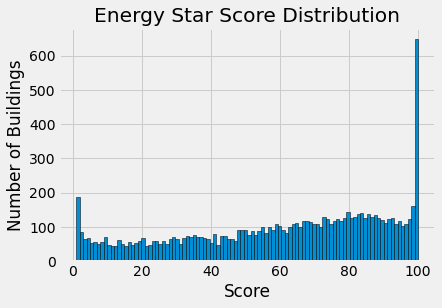

In [17]:
# Построить графики зависимости переменных, найти зависимости

# Гистограмма Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['ENERGY STAR Score'].dropna(), bins = 100, edgecolor = 'k')
plt.xlabel('Score')
plt.ylabel('Number of Buildings')
plt.title('Energy Star Score Distribution')

Text(0.5, 1.0, 'Site EUI Distribution')

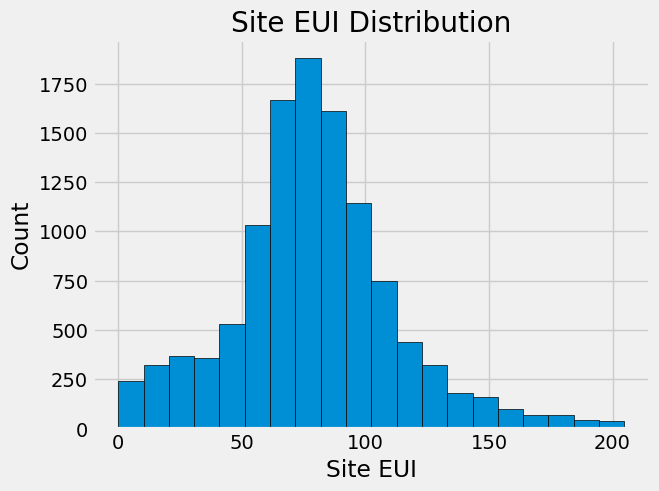

In [8]:
# Гистограмма Site EUI
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black')
plt.xlabel('Site EUI');
plt.ylabel('Count')
plt.title('Site EUI Distribution')

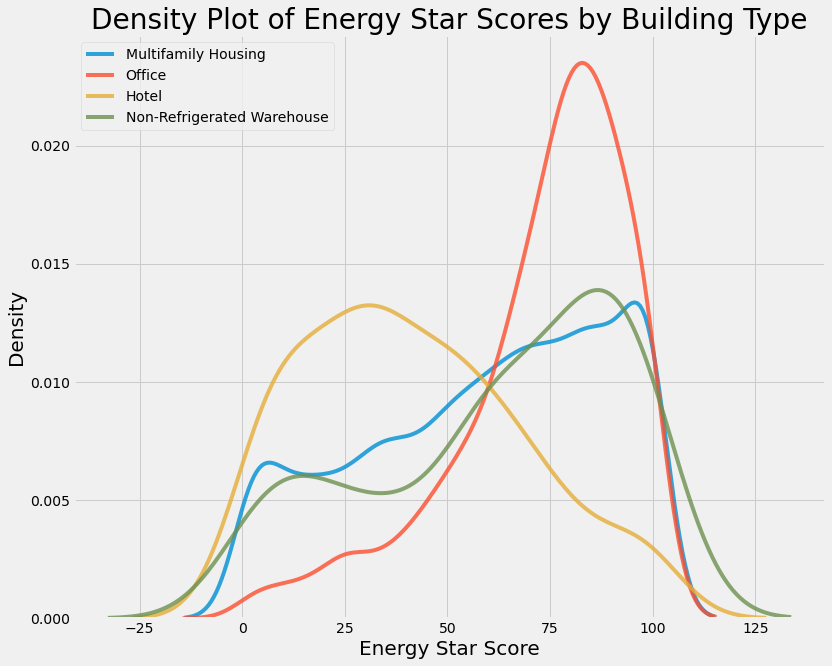

In [18]:
# Список зданий с >100 измерениями
types = data.dropna(subset=['ENERGY STAR Score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

# График распределения Energy Star scores по типам зданий
plt.figure(figsize=(12, 10))

# Список типов зданий
for b_type in types:
    # Выбор типов зданий
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # График плотности
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = b_type, fill = False, alpha = 0.8);
    
# Легенда и названия
plt.xlabel('Energy Star Score', size = 20)
plt.ylabel('Density', size = 20); 
plt.legend(types)
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

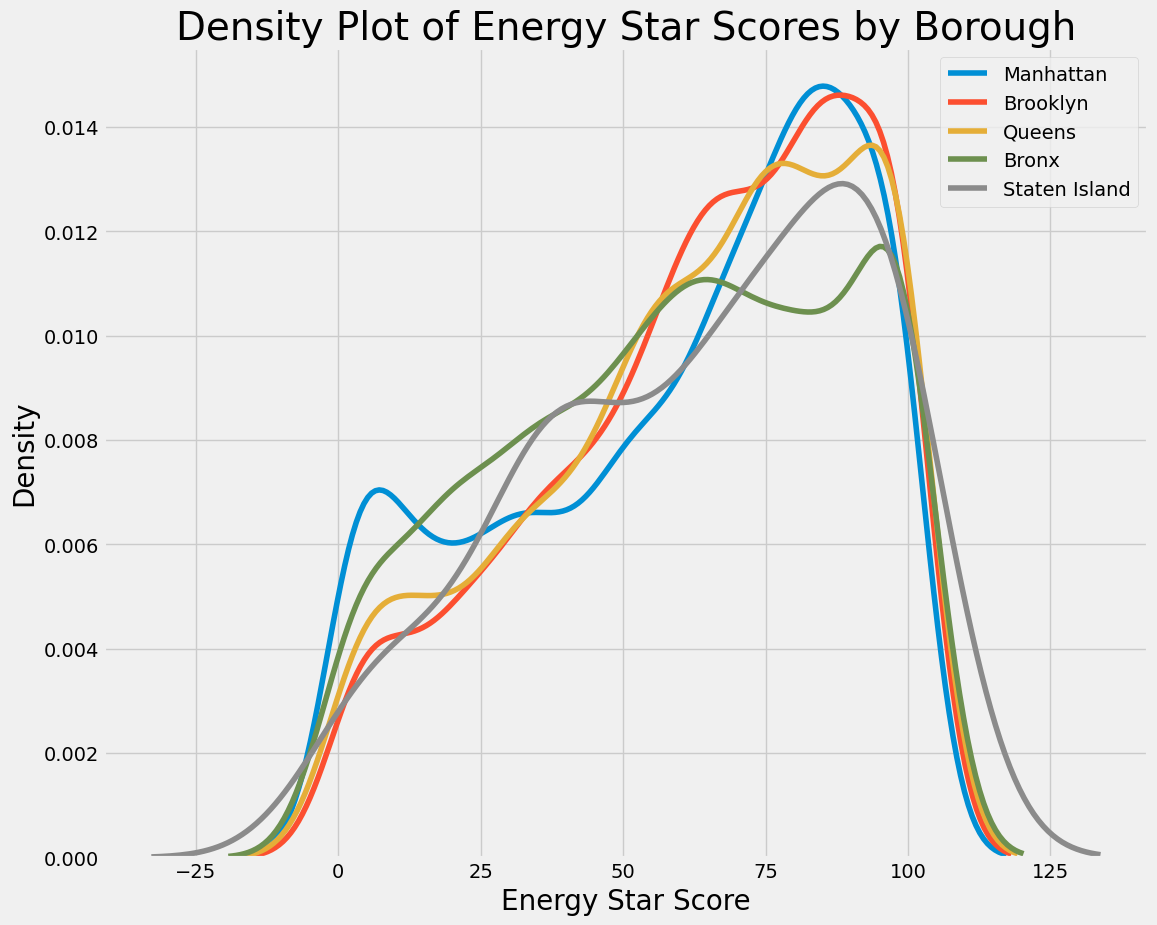

In [10]:
# Создание списка районов с более чем 100 измерениями
boroughs = data.dropna(subset=['ENERGY STAR Score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

plt.figure(figsize=(12, 10))

# Список районов
for borough in boroughs:
    # Выбор района
    subset = data[data['Borough'] == borough]
    
    # График плотности Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = borough)
    
# Легенда и названия
plt.xlabel('Energy Star Score', size = 20)
plt.ylabel('Density', size = 20) 
plt.legend(boroughs)
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

In [11]:
# Коэффициенты корреляции
correlations_data = data.corr()['ENERGY STAR Score'].sort_values()
correlations_data

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

In [19]:
# Создание новых признаков

# Копирование изначальных данных
features = data.copy()

# Выбор числовых данных
numeric_subset = data.select_dtypes('number')

# Прогоняем все признаки через log и делаем их категориальными

for col in numeric_subset.columns:
    # Пропускаем ENERGY STAR Score
    if col == 'ENERGY STAR Score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Выбор категориальных данных
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Объединение данных
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in l

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),...,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
12,15,2637863,NaN,412503.0,1903,2,100,93.0,32.0,NaN,...,0,0,0,0,0,0,0,0,0,0
17,20,2777309,NaN,323000.0,1907,7,100,NaN,120.0,125.2,...,0,0,0,0,0,0,0,0,0,0
18,21,2780056,NaN,321464.0,1939,2,100,72.0,76.2,79.9,...,0,0,0,0,0,0,0,0,0,0
19,22,4988574,179130.0,204720.0,1939,1,100,67.0,75.7,79.0,...,0,0,0,0,0,0,0,0,0,0
20,23,4988569,102150.0,116744.0,1939,1,100,80.0,77.1,82.7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,14988,4940453,70645.0,74177.0,1928,1,100,98.0,81.4,87.0,...,0,0,0,0,0,0,0,0,0,0
11742,14989,4940416,93500.0,93500.0,1926,1,100,16.0,109.3,117.7,...,0,0,0,0,0,0,0,0,0,0
11743,14990,4628296,NaN,103328.0,1913,1,95,83.0,44.3,43.9,...,0,0,0,0,0,0,0,0,0,0
11744,14991,4940464,57824.0,60715.0,1928,1,100,92.0,70.0,74.9,...,0,0,0,0,0,0,0,0,0,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = 

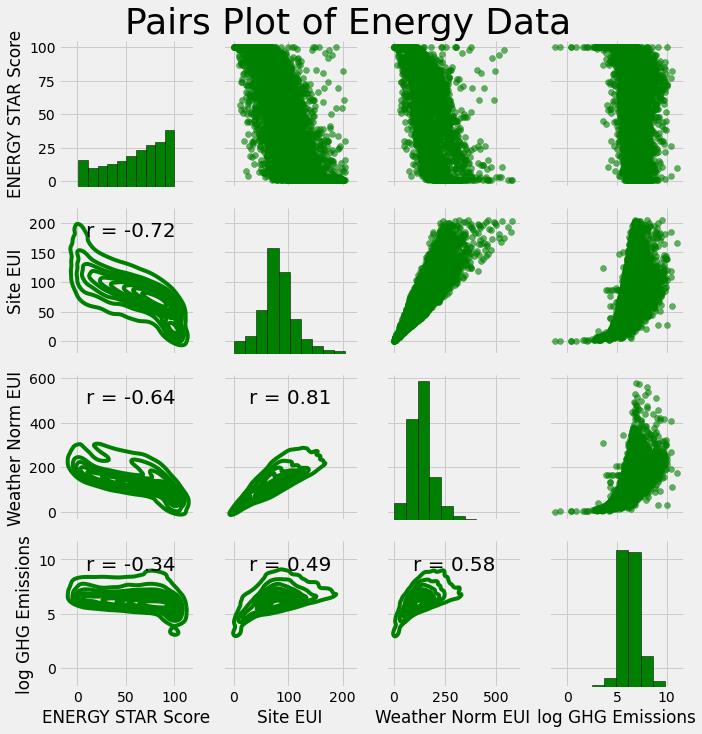

In [22]:
# Извлечение данных для графика
plot_data = features[['ENERGY STAR Score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

#Заменяем inf на nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Переименовываем колонки
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Избавляемся от na
plot_data = plot_data.dropna()

# функция для рассчета корреляции
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Создаем PairGrid
grid = sns.PairGrid(data = plot_data)

grid.map_upper(plt.scatter, color = 'green', alpha = 0.6)

grid.map_diag(plt.hist, color = 'green', edgecolor = 'black')

grid.map_lower(corr_func, color='green', edgecolor='black')
grid.map_lower(sns.kdeplot, color='green', edgecolor='black')

# Название графика
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

In [23]:
# Оставить все колонки с коэфициентом кореляции 0.6 и выше

# Функция для удаления коррелированных данных
# с коэффицентом корреляции больше порога threshhold
def corr_df(x, threshold):
    
    # Временно сохраняем ENERGY STAR Score чтобы не удалить его в процессе
    y = x['ENERGY STAR Score']
    x = x.drop(columns = ['ENERGY STAR Score'])
    
    # Рассчет матрицы корреляции
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Сравнение корреляций
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # Если корреляция больше порога
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Удаляем один столбец из пары коррелированных
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Возвращаем ENERGY STAR Score
    x['ENERGY STAR Score'] = y
               
    return x

features = corr_df(features, 0.6);

# Удалить все колонки со значением na
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

In [24]:
# Извлекаем здания с ENERGY STAR Score и без
no_score = features[features['ENERGY STAR Score'].isna()]
score = features[features['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [25]:
# Разделяем признаки и целевые данные
features = score.drop(columns='ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Заменяем inf на nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Делим на 70% учебных и 30% тестовых данных
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


In [26]:
# Функция для рассчета средней абсолютной ошибки
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred), axis=0)

baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 24.5164


In [27]:
X_nonan = X.copy()
X_nonan_test = X_test.copy()
X_nonan.fillna(X_nonan.mean(), inplace=True)
X_nonan_test.fillna(X_nonan_test.mean(), inplace=True)

regr = LinearRegression()
regr.fit(X_nonan, y)
lin_guess = regr.predict(X_nonan_test)

print('The baseline guess is a score of %0.2f' % regr.score(X_nonan_test, y_test))
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, lin_guess))

The baseline guess is a score of 0.66
Baseline Performance on the test set: MAE = 13.4892


In [28]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
y_1d = y.copy().to_numpy().ravel()
regr.fit(X_nonan, y_1d)
svr_guess = regr.predict(X_nonan_test)
y_1d_test = y_test.copy().to_numpy().ravel()

print('The baseline guess is a score of %0.2f' % regr.score(X_nonan_test, y_1d_test))
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_1d_test, svr_guess))

The baseline guess is a score of 0.67
Baseline Performance on the test set: MAE = 12.7291


In [29]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_nonan, y_1d)
rfg_guess = regr.predict(X_nonan_test)

print('The baseline guess is a score of %0.2f' % regr.score(X_nonan_test, y_1d_test))
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_1d_test, rfg_guess))

The baseline guess is a score of 0.52
Baseline Performance on the test set: MAE = 15.6346


In [30]:
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_nonan, y_1d)
gbr_guess = regr.predict(X_nonan_test)

print('The baseline guess is a score of %0.2f' % regr.score(X_nonan_test, y_1d_test))
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_1d_test, gbr_guess))

The baseline guess is a score of 0.78
Baseline Performance on the test set: MAE = 10.0823


In [31]:
regr = KNeighborsRegressor()
regr.fit(X_nonan, y_1d)
knr_guess = regr.predict(X_nonan_test)

print('The baseline guess is a score of %0.2f' % regr.score(X_nonan_test, y_1d_test))
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_1d_test, knr_guess))

The baseline guess is a score of -0.13
Baseline Performance on the test set: MAE = 25.9068
